In [1]:
import logging

import torch
import torch.optim as optim

from robustbench.data import load_cifar10c
from robustbench.model_zoo.enums import ThreatModel
from robustbench.utils import load_model
from nets import *

import time
import tent
import norm
import oracle
from utils import *
from matplotlib import pyplot as plt


import ipdb

from conf import cfg, load_cfg_fom_args, merge_from_file

corruption_list = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness',
                        'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']


In [2]:
logger = logging.getLogger(__name__)
#TODO: build multistage.yaml
merge_from_file('cfgs/multistage.yaml')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(cfg)

BN:
  EPS: 1e-05
  MOM: 0.1
CKPT_DIR: ./ckpt
CORRUPTION:
  DATASET: cifar10
  NUM_EX: 10000
  SEVERITY: [3]
  TYPE: ['gaussian_noise']
CUDNN:
  BENCHMARK: True
DATA_DIR: /gallery_tate/wonjae.roh
DESC: 
EPOCH: 50
EXPERIMENTAL:
  LINEAR_RETRAIN: False
ITERATION: 1
LOG_DEST: log.txt
LOG_TIME: 
MODEL:
  ADAPTATION: tent
  ARCH: Hendrycks2020AugMix_WRN
  EPISODIC: False
OPTIM:
  BETA: 0.9
  DAMPENING: 0.0
  LR: 0.001
  METHOD: Adam
  MOMENTUM: 0.9
  NESTEROV: True
  STEPS: 1
  WD: 0.0
RNG_SEED: 1
SAVE_DIR: ./output
TEST:
  BATCH_SIZE: 200


### adaptation 없이 initial high_entropy samples, low_entropy samples index 찾기

In [3]:
def setup_tent(model):
    """Set up tent adaptation.

    Configure the model for training + feature modulation by batch statistics,
    collect the parameters for feature modulation by gradient optimization,
    set up the optimizer, and then tent the model.
    """
    model = tent.configure_model(model)
    params, param_names = tent.collect_params(model)
    optimizer = setup_optimizer(params)
    tent_model = tent.Tent(model, optimizer,
                           steps=cfg.OPTIM.STEPS,
                           episodic=cfg.MODEL.EPISODIC)
    logger.info(f"model for adaptation: %s", model)
    logger.info(f"params for adaptation: %s", param_names)
    logger.info(f"optimizer for adaptation: %s", optimizer)
    return tent_model

def setup_optimizer(params):
    """Set up optimizer for tent adaptation.

    Tent needs an optimizer for test-time entropy minimization.
    In principle, tent could make use of any gradient optimizer.
    In practice, we advise choosing Adam or SGD+momentum.
    For optimization settings, we advise to use the settings from the end of
    trainig, if known, or start with a low learning rate (like 0.001) if not.

    For best results, try tuning the learning rate and batch size.
    """
    if cfg.OPTIM.METHOD == 'Adam':
        return optim.Adam(params,
                    lr=cfg.OPTIM.LR,
                    betas=(cfg.OPTIM.BETA, 0.999),
                    weight_decay=cfg.OPTIM.WD)
    elif cfg.OPTIM.METHOD == 'SGD':
        return optim.SGD(params,
                   lr=cfg.OPTIM.LR,
                   momentum=cfg.OPTIM.MOMENTUM,
                   dampening=cfg.OPTIM.DAMPENING,
                   weight_decay=cfg.OPTIM.WD,
                   nesterov=cfg.OPTIM.NESTEROV)
    else:
        raise NotImplementedError
    
def setup_source(model):
    """Set up the baseline source model without adaptation."""
    model.eval()
    logger.info(f"model for evaluation: %s", model)
    return model

In [4]:

# configure model

if cfg.MODEL.ARCH == "Hendrycks2020AugMix_WRN":
    base_model = load_model(cfg.MODEL.ARCH, cfg.CKPT_DIR, cfg.CORRUPTION.DATASET, ThreatModel.corruptions).to(device)
elif cfg.MODEL.ARCH == "RN18":
    base_model = ResNet18(n_classes=10)
    ckpt = torch.load("/home2/wonjae.roh/nprc/tent/ckpt/cifar10/corruptions/ResNet18_pretrained.pth.tar", map_location=device)
    base_model.load_state_dict(ckpt["pretrain-learner"])
else:
    raise NotImplementedError


x_test, y_test = load_cifar10c(cfg.CORRUPTION.NUM_EX, cfg.CORRUPTION.SEVERITY[0], cfg.DATA_DIR, False, cfg.CORRUPTION.TYPE)
x_test, y_test = x_test.to(device), y_test.to(device)

acc, outputs = get_stats(base_model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True)



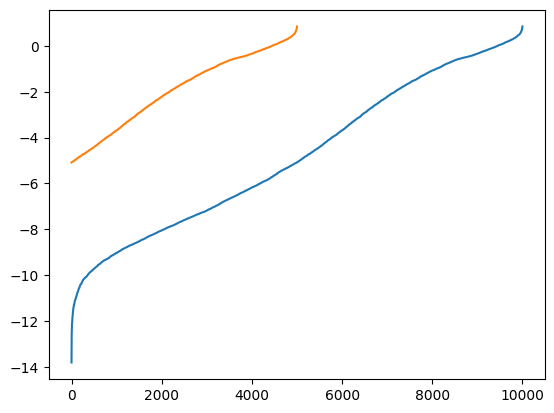

In [5]:
%matplotlib inline

entropy = tent.softmax_entropy(outputs)
entropy = torch.log2(entropy)
entropy_sorted, entropy_sorted_index = entropy.sort()
plt.plot(entropy_sorted.numpy())

high_index = entropy_sorted_index[5000:]
low_index = entropy_sorted_index[:5000]
high_values = entropy[high_index]
low_values = entropy[low_index]
plt.plot(high_values.numpy())

### Correct samples, Wrong samples entropy histogram visualize

                 0
count  7955.000000
mean     -5.570647
std       3.052094
min     -13.812100
25%      -8.017754
50%      -6.080189
75%      -3.084206
max       0.750064
                 0
count  2045.000000
mean     -1.759805
std       2.239306
min     -12.338400
25%      -2.637235
50%      -0.935519
75%      -0.192706
max       0.845291


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          2.,   0.,   0.,   1.,   1.,   2.,   1.,   1.,   0.,   2.,   2.,
          1.,   2.,   1.,   4.,   3.,   3.,   6.,   6.,   0.,   1.,   2.,
          6.,   2.,   7.,   6.,   6.,  11.,   4.,   4.,   3.,   8.,   6.,
          9.,   5.,   7.,   9.,  12.,  12.,  13.,   7.,   8.,  19.,  12.,
         17.,  13.,   9.,   8.,  14.,   5.,  12.,  11.,  21.,  18.,  16.,
         15.,  20.,  14.,  23.,  18.,  22.,  24.,  22.,  29.,  25.,  26.,
         38.,  29.,  31.,  43.,  37.,  43.,  51.,  47.,  64.,  68.,  63.,
         87., 120., 108.,  92., 101.,  92.,  96.,  89.,  69.,  45.,  22.,
          9.]),
 array([-12.33839989, -12.206563  , -12.0747261 , -11.94288921,
        -11.81105232, -11.67921543, -11.54737854, -11.41554165,
        -11.28370476, -11.15186787, -11.02003098, -10.88819408,
        -10.75635719, -10.6245203 , -10.49268341, -10.36084652,
        -10.22900963, -10.09717274,  -9.96533585,  -9.83349895

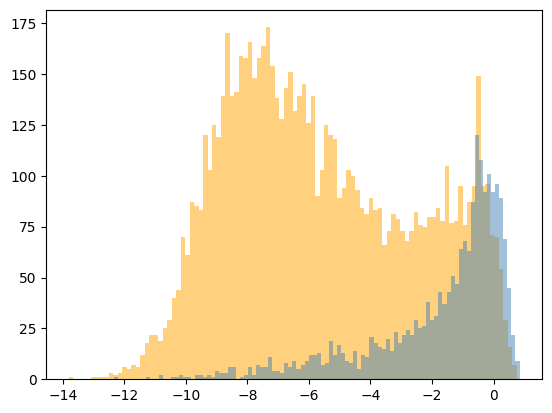

In [6]:
import pandas as pd

data_dir = "/gallery_tate/wonjae.roh/cifar10c"
labels_path = data_dir + '/labels.npy'
labels = np.load(labels_path)
# labels는 10000 sample, 5 severity에 대해 10000개의 같은 label이 5번 반복되는 형태이므로 잘라준다
labels = labels[:10000]

predicted = outputs.argmax(axis=1).numpy()

correct = predicted==labels
wrong = ~correct
entropy_numpy = entropy.numpy()

correct_entropy = entropy_numpy[correct]
wrong_entropy = entropy_numpy[wrong]

correct_describe = pd.DataFrame(correct_entropy)
print(correct_describe.describe())
wrong_describe = pd.DataFrame(wrong_entropy)
print(wrong_describe.describe())

plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [7]:
threshold = entropy_sorted[5000].item()
print(f'threshold : {threshold:.4f}') 

correct_high = np.sum(correct_describe > threshold)
correct_low = np.sum(correct_describe < threshold)
wrong_high = np.sum(wrong_describe > threshold)
wrong_low = np.sum(wrong_describe < threshold)

print(f'low_error : {1-float(correct_low * 100 / (correct_low + wrong_low)):.2f}')
print(f'high_error : {1-float(correct_high * 100 / (correct_high + wrong_high)):.2f}') 

threshold : -5.0855
high entropy accuracy : 0    0.634727
dtype: float64
low entropy accuracy : 0    0.9562
dtype: float64


### Dataloader (low_entropy, high_entropy, all)

In [8]:
def get_subset(x, y, indices, shuffle=False):
    """get subset of data from indices
    Args:
    x: data
    y: labels
    indices: indices to get subset
    Returns:
    subset of data and labels
    """
    x_sub = x[indices]
    y_sub = y[indices]

    if shuffle:
        rand_idx = np.random.permutation(np.arange(len(x_sub)))
        x_sub, y_sub = x_sub[rand_idx], y_sub[rand_idx]

    return x_sub, y_sub
        
x_low, y_low = get_subset(x_test, y_test, low_index, shuffle=True)
x_high, y_high = get_subset(x_test, y_test, high_index, shuffle=True)     

### adaptation with suitable dataset (all)

In [9]:
def vis_entropy_histogram(outputs, labels):
    entropy = tent.softmax_entropy(outputs)
    entropy = torch.log2(entropy)
    entropy_numpy = entropy.numpy()
    labels = labels.numpy()

    predicted = outputs.argmax(axis=1).numpy()

    correct = predicted==labels
    wrong = ~correct

    correct_entropy = entropy_numpy[correct]
    wrong_entropy = entropy_numpy[wrong]


    correct_describe = pd.DataFrame(correct_entropy)
    print(correct_describe.describe())
    wrong_describe = pd.DataFrame(wrong_entropy)
    print(wrong_describe.describe())

    plt.hist(correct_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='orange', edgecolor='none')
    plt.hist(wrong_describe, bins=100, density=False, alpha=0.5, histtype='stepfilled', color='steelblue', edgecolor='none')

In [10]:
if cfg.MODEL.ADAPTATION == "tent":
    logger.info("test-time adaptation: TENT")
    model = setup_tent(base_model)
elif cfg.MODEL.ADAPTATION == "source":
    logger.info("test-time adaptation: SOURCE")
    model = setup_source(base_model)

In [11]:
model.reset()

# check if it only prints desirable updating parameters
check_freeze(model.model)
 

block1.layer.0.bn1.weight
block1.layer.0.bn1.bias
block1.layer.0.bn2.weight
block1.layer.0.bn2.bias
block1.layer.1.bn1.weight
block1.layer.1.bn1.bias
block1.layer.1.bn2.weight
block1.layer.1.bn2.bias
block1.layer.2.bn1.weight
block1.layer.2.bn1.bias
block1.layer.2.bn2.weight
block1.layer.2.bn2.bias
block1.layer.3.bn1.weight
block1.layer.3.bn1.bias
block1.layer.3.bn2.weight
block1.layer.3.bn2.bias
block1.layer.4.bn1.weight
block1.layer.4.bn1.bias
block1.layer.4.bn2.weight
block1.layer.4.bn2.bias
block1.layer.5.bn1.weight
block1.layer.5.bn1.bias
block1.layer.5.bn2.weight
block1.layer.5.bn2.bias
block2.layer.0.bn1.weight
block2.layer.0.bn1.bias
block2.layer.0.bn2.weight
block2.layer.0.bn2.bias
block2.layer.1.bn1.weight
block2.layer.1.bn1.bias
block2.layer.1.bn2.weight
block2.layer.1.bn2.bias
block2.layer.2.bn1.weight
block2.layer.2.bn1.bias
block2.layer.2.bn2.weight
block2.layer.2.bn2.bias
block2.layer.3.bn1.weight
block2.layer.3.bn1.bias
block2.layer.3.bn2.weight
block2.layer.3.bn2.bias


error : 12.37


In [ ]:
# adapt on low entropy samples
acc_total, outputs_total = get_stats(model, x_test, y_test, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'error : {(1-acc_total)*100:.2f}') 

### adaptation with suitable dataset (low)

In [12]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)
print(f'low_error : {(1-acc_low)*100:.2f}')  

# without updating, check on high entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 


low_error : 4.14
high_error : 24.20
total_error : 14.17


                 0
count  4793.000000
mean     -5.760878
std       1.998753
min     -11.874347
25%      -7.096090
50%      -6.118214
75%      -4.786353
max       1.109442
                0
count  207.000000
mean    -1.682775
std      2.208834
min     -9.068273
25%     -2.801388
50%     -0.999047
75%     -0.083469
max      1.128290


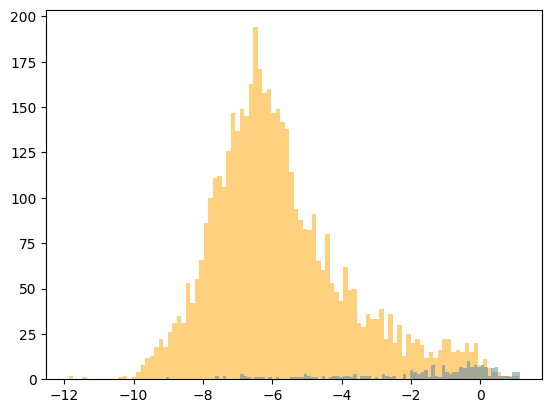

In [13]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3790.000000
mean     -3.489638
std       2.292751
min     -12.269102
25%      -5.113988
50%      -3.410256
75%      -1.582549
max       0.931119
                 0
count  1210.000000
mean     -1.187651
std       1.543310
min      -8.696940
25%      -1.839386
50%      -0.651498
75%      -0.144974
max       0.965510


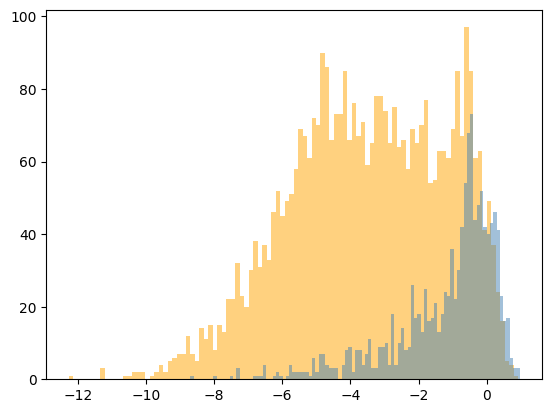

In [14]:
vis_entropy_histogram(outputs_high, y_high)

### adaptation with suitable dataset (high)

In [15]:
model.reset()

# check if it only prints desirable updating parameters
# check_freeze(model.model)

# adapt on low entropy samples
acc_high, outputs_high = get_stats(model, x_high, y_high, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=False)

# without updating, check on high entropy samples
acc_low, outputs_low = get_stats(model, x_low, y_low, cfg.TEST.BATCH_SIZE, device=device,
                                        iteration=1,
                                        corruption_type=cfg.CORRUPTION.TYPE,
                                        return_raw=True, no_grad=True) 
print(f'low_error : {(1-acc_low)*100:.2f}')  
print(f'high_error : {(1-acc_high)*100:.2f}')  
acc_total = (acc_low + acc_high) / 2
print(f'total_error : {(1-acc_total)*100:.2f}') 

low_error : 4.50
high_error : 23.18
total_error : 13.84


                 0
count  4775.000000
mean     -6.246374
std       2.049893
min     -12.039067
25%      -7.598366
50%      -6.620950
75%      -5.354223
max       0.985731
                0
count  225.000000
mean    -1.727292
std      2.225833
min     -8.905988
25%     -2.706589
50%     -0.806758
75%     -0.129230
max      1.061450


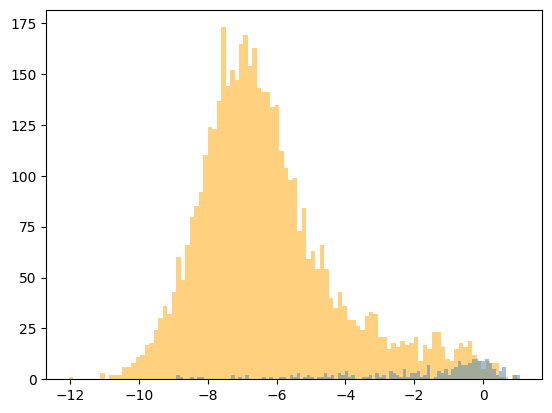

In [16]:
vis_entropy_histogram(outputs_low, y_low)

                 0
count  3841.000000
mean     -3.274905
std       2.287929
min     -12.425218
25%      -4.947685
50%      -3.225013
75%      -1.334947
max       1.171686
                 0
count  1159.000000
mean     -0.756209
std       1.325366
min      -8.227887
25%      -1.253066
50%      -0.432920
75%       0.146052
max       1.168576


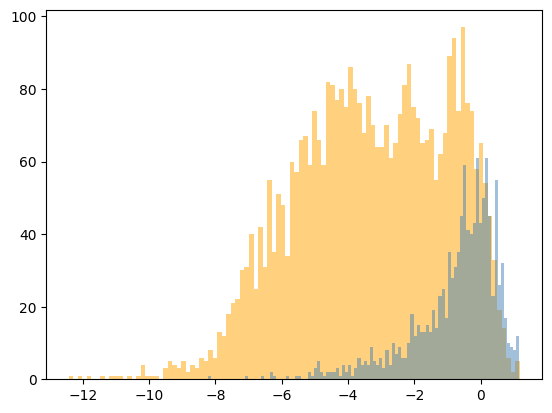

In [17]:
vis_entropy_histogram(outputs_high, y_high)

ResNet18 기준으로는 차이가 좀 나네